# How to rediscover the Higgs boson yourself!

<CENTER><img src="images/ImagesHiggs/ATLASOD.gif" style="width:50%"></CENTER>

This notebook uses ATLAS Open Data https://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text


### What is the Higgs boson? 
The Higgs boson is a fundamental particle predicted by the Standard Model. 
It is a manifestation of the Higgs field,
    which gives mass to the fundamental particles.
However,
    it is incredibly hard to produce.
At the LHC, 
    a Higgs particle is produced about once every 10 billion collisions!
This tiny fraction makes it very difficult to detect.
Nevertheless, 
    after years of data collection, 
    the Higgs boson was finally discovered in 2012 by CMS and ATLAS experiments at CERN.
In this tutorial, 
    we shall be following their example. 


### Detecting the Higgs
This analysis loosely follows the paper on the [discovery of the Higgs boson by ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1).

The Higgs boson can be produced in many different ways. 
In particle physics, 
    we describe these production modes using Feynman diagrams.
These diagrams allow us to visualise particle processes while also acting as powerful tools for calculations.
See [here](https://cds.cern.ch/record/2759490/files/Feynman%20Diagrams%20-%20ATLAS%20Cheat%20Sheet.pdf) for more information on Feynman diagrams.

There are four main production modes of the Higgs boson, and their respective Feynman diagrams:
1. Gluon-gluon fusion (top left)
2. Vector boson fusion (top right)
3. Vector boson bremsstrahlung (bottom left)
4. Top-antitop fusion (bottom right)

<CENTER><img src="images/ImagesHiggs/ggH.png" style="width:40%"> <img src="images/ImagesHiggs/VBFH.png" style="width:35%"></CENTER>
<CENTER><img src="images/ImagesHiggs/WH.png" style="width:40%"> <img src="images/ImagesHiggs/ttbarfusion.png" style="width:35%"></CENTER>

The Higgs has a very short lifetime,
    on the order of $10^{-22} \,\text{s}$.
It decays extremely quickly after production,
    so there is no hope of directly detecting the particle.
Nevertheless,
    we can use the Standard Model to predict its 
    decay products: photons, Z bosons, quarks, etc.,
    all with different probabilities.
These **decay channels** can be used to identify the Higgs boson.
In this notebook, 
    we'll be looking at one particular decay channel:
$$H \rightarrow ZZ^* \rightarrow \ell\ell\ell\ell$$

<CENTER><img src="images/ImagesHiggs/HZZ_feynman.png" style="width:40%"></CENTER>


We refer to this as our desired **signal**.
Ideally,
    we would search for collisions which yield four leptons as products and this would tell us that a Higgs boson is present.
Unfortunately,
    in addition to our signal,
    there are many other **background** processes that lead to four reconstructed leptons in the final state. 
The main background is $ZZ^*  \to \ell\ell\ell\ell$,
    where decay products have the same properties as those in the Higgs decay. 
This is known as an irreducible background. 
<CENTER><img src="images/ImagesHiggs/ZZllll.png" style="width:40%"></CENTER>

We can get around this by accounting for the total invariant mass of the lepton products. 
We know through conservation of energy and momentum that the invariant mass of the products must be equal to the Higgs mass, 
    while other background processes will have different invariant masses. 
Our last step would be to plot the invariant mass of each event and spot the peak in mass around $125\, \text{GeV}$ , which corresponds to the mass of the Higgs boson. 

We also have background contributions from $Z +$ jets and top-anti top processes, 
    where additional charged leptons can arise either from semi-leptonic decays of heavy flavour or light flavour jets misidentified as leptons.
These backgrounds are difficult to remove completely. 

<CENTER><img src="images/ImagesHiggs/Zllll.png" style="width:30%"><img src="images/ImagesHiggs/ttbar.png" style="width:30%"></CENTER>

For such processes,
    we will attempt to distinguish them from the Higgs decay using the properties of the leptons.
Because the Higgs is a neutral particle with zero lepton number,
    the lepton products from its decay must sum to zero charge and zero lepton numbers.
Thus, 
    we can cut away all data with products that do not have these properties.
These cuts increase the ratio of our signal to the reducible background.

Note: $Z^*$ refers to a $Z$ boson that is off its mass shell. 
This means that its mass is not fixed to the $91 \, \text{GeV}$ of a typical $Z$ boson. 

By the end of this notebook you will be able to:
1. Learn to process large data sets using cuts
2. Understand some general principles of a particle physics analysis
3. Discover the Higgs boson!

See [here](https://cds.cern.ch/record/2800577/files/Signal%20and%20Background%20Physics%20Cheat%20Sheet.pdf) for more information on signals and backgrounds!

### Running a Python notebook
A Python notebook consists of cell blocks, 
    each containing lines of Python code.
Each cell can be run independently of each other,
    yielding respective outputs below the cells.
Conventionally,
    cells are run in order from top to bottom.


- To run the whole notebook, in the top menu click Cell $\to$ Run All.

- To propagate a change you've made to a piece of code, click Cell $\to$ Run All Below.

- You can also run a single code cell, by clicking Cell $\to$ Run Cells, or using the keyboard shortcut Shift+Enter.

For more information, 
    refer to [here](https://www.codecademy.com/article/how-to-use-jupyter-notebooks).

## ATLAS Open Data Initialisation

### First time package installation on your computer (not needed on mybinder)
This first cell installs the required python packages.
It only needs to be run the first time you open this notebook on your computer. 
If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If this is opened on mybinder, you don't need to run this cell.

In [ ]:
import sys
# # update the pip package installer
!{sys.executable} -m pip install --upgrade --user pip
# # install required packages
!{sys.executable} -m pip install --upgrade --user uproot awkward vector numpy matplotlib

We're going to import a number of packages to help us:
* `numpy`: provides numerical calculations such as histogramming
* `matplotlib`: common tool for making plots, figures, images, visualisations
* `uproot`: processes `.root` files typically used in particle physics into data formats used in python
* `awkward`: introduces `awkward` arrays, a format that generalizes `numpy` to nested data with possibly variable length lists
* `vector`: to allow vectorized 4-momentum calculations

We also import the file `infofile`, which contains all relevant information of our dataset.

In [28]:
import infofile # local file containing cross-sections, sums of weights, dataset IDs
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time

Unit definitions, as stored in the data files

In [29]:
MeV = 0.001
GeV = 1.0

## Example 1: Reading data 

We would like to read some of the data from the open dataset.

In [30]:
# ATLAS Open Data directory
path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" 

For convenient naming and identification purposes,
    we define a dictionary which stores all the important names of the samples we want to pull from the directory.

In [31]:
# For identification and naming
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'], # data is from 2016, first four periods of data taking (ABCD)
    },

    r'Background $Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },

    r'Background $ZZ^*$' : { # ZZ
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },

    r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#00cdff" # light blue
    },

}

The key named `data` refers to the event information collected from real experiments,
    while the `Background` and `Signal` keys refer to Monte-Carlo (MC) simulations of the ATLAS experiments.
Both real data and MC data will then be analysed and compared together to discover the Higgs! 

Let's try accessing `data_A` in the Open Data URL as an example.

In [32]:
# Print the samples dict for the key 'data'
print(samples['data'])

# We shall use the first entry in 'list', 'data_A'
value = samples['data']['list'][0]
print(f"{value=}")

# This is now appended to our file path to retrieve the data_A.4lep.root file
data_A_path = path + "Data/" + value + ".4lep.root"

{'list': ['data_A', 'data_B', 'data_C', 'data_D']}
value='data_A'


Next, we shall try opening the `data_A` file to see what is inside.
In the file (called a `tree`),
    there are 39 entries, 
    one for each event.
In each event,
    a dictionary stores the all relevant information as keys, such as the event number (`eventNumber`), lepton transverse momentum (`lep_pt`), etc.  
Details on the variables in the dictionary can be viewed [here](https://cds.cern.ch/record/2707171/files/ANA-OTRC-2019-01-PUB-updated.pdf) in Appendix A.

More information on trees can be viewed [here](https://masonproffitt.github.io/uproot-tutorial/03-trees/index.html).

In [33]:
# Accessing the file from the online directory (":mini" opens the tree in a desired manner)
with uproot.open(data_A_path + ":mini") as t:
    tree = t

# There are 39 entries in the tree
print(tree.num_entries)

# We can view all the information stored in the tree using the .keys() method.
print(tree.keys())

# We can also view the entire tree using the .arrays() method
# This generates a 39-entry list of dictionaries
print(tree.arrays()) 

39
['runNumber', 'eventNumber', 'channelNumber', 'mcWeight', 'scaleFactor_PILEUP', 'scaleFactor_ELE', 'scaleFactor_MUON', 'scaleFactor_PHOTON', 'scaleFactor_TAU', 'scaleFactor_BTAG', 'scaleFactor_LepTRIGGER', 'scaleFactor_PhotonTRIGGER', 'trigE', 'trigM', 'trigP', 'lep_n', 'lep_truthMatched', 'lep_trigMatched', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_z0', 'lep_charge', 'lep_type', 'lep_isTightID', 'lep_ptcone30', 'lep_etcone20', 'lep_trackd0pvunbiased', 'lep_tracksigd0pvunbiased', 'met_et', 'met_phi', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_jvt', 'jet_trueflav', 'jet_truthMatched', 'jet_MV2c10', 'photon_n', 'photon_truthMatched', 'photon_trigMatched', 'photon_pt', 'photon_eta', 'photon_phi', 'photon_E', 'photon_isTightID', 'photon_ptcone30', 'photon_etcone20', 'photon_convType', 'tau_n', 'tau_pt', 'tau_eta', 'tau_phi', 'tau_E', 'tau_isTightID', 'tau_truthMatched', 'tau_trigMatched', 'tau_nTracks', 'tau_BDTid', 'ditau_m', 'lep_pt_syst', 'met_et_syst', 'jet_pt_syst',

Perhaps we'd like to see the lepton energies. 
We can access this from our tree using the key `lep_E`. 
Also, 
    from this point on we shall be manipulating our tree arrays using the `awkward` library.
We can use `library="ak"` in the argument of the `.arrays()` method to use this library.
If you ever see `library="ak"` in the code,
    it means that the array is output as an `awkward` array.

In [34]:
tree["lep_E"].arrays(library="ak")

<Array [{lep_E: [1.34e+05, ...]}, ..., {...}] type='39 * {lep_E: var * floa...'>

In our analysis, 
    not all the information in the tree is important.
We can store the important variables in a list and retrieve them from the tree later on.
As it turns out, 
    we will need the following set of variables:

In [35]:
# Define what variables are important to our analysis
variables = ['lep_pt','lep_eta','lep_phi','lep_E','lep_charge','lep_type']

# To see all the data for our given variables
# for data in tree.iterate(variables, library="ak"):
#     print(data)

Now that we understand how to access the information in the `data_A` tree,
    we can begin analysis.
As mentioned in the introduction,
    there are two key steps to be completed for each event entry:
1. **Cuts** - we need to account for lepton selection rules in the event. 
In the [paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X), 
    it is stated that we must
"[select] two pairs of isolated leptons, each of which is comprised of two leptons with the **same flavour** and **opposite charge**".
The datasets used in this notebook have already been filtered to include at least 4 leptons per event.
We need to filter the data such that in each event, there are pairs of leptons of the **same lepton type** (`lep_type`) and summing to **zero lepton charge** (`lep_charge`).

2. **Mass calculation** - the data to be plotted is the 4-lepton invariant mass, which can be found using the equation: $$m_\text{4l} = \sqrt{E^2_\text{tot}-\mathbf{p}_\text{tot}\cdot\mathbf{p}_\text{tot}}$$
in units where $c=1$.
$E_\text{tot}$ is the total energy and $\mathbf{p}_\text{tot}$ is the total momentum.
This calculation is performed using the vector array method `.M` on the sum of lepton 4-momenta (`lep_pt`,`lep_eta`,`lep_phi`,`lep_E`).

From this,
    we can see why we chose those six important variables earlier. 
The physical reasoning for why we perform these steps is encapsulated in the idea of **conservation laws**.
You may read more [here](https://cds.cern.ch/record/2759491/files/Conservation%20Laws%20-%20ATLAS%20Physics%20Cheat%20Sheet.pdf).

Let's try to perform this two-step analysis for one event in `data_A`.

In [36]:
# This selects the first entry of the tree
entry = tree.arrays(library="ak")[:1] 

# Cut lepton type (electron type is 11,  muon type is 13)
lep_type = entry['lep_type']
sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
lep_type_cut_bool = (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)
print(f"Cut for lepton type? {lep_type_cut_bool}") # True means we should remove this entry (lepton type does not match)

# Cut lepton charge
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
lep_charge = entry['lep_charge']
sum_lep_charge = lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] != 0
print(f"Cut for lepton charge? {sum_lep_charge}") # True means we should remove this entry (sum of lepton charges is not equal to 0)

# Calculate invariant mass of the 4-lepton state
# [:, i] selects the i-th lepton in each event
p4 = vector.zip({"pt": entry['lep_pt'], "eta": entry['lep_eta'], "phi": entry['lep_phi'], "E": entry['lep_E']})
invariant_mass = (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M * MeV # .M calculates the invariant mass
print(f"Invariant mass: {invariant_mass}")

Cut for lepton type? [False]
Cut for lepton charge? [True]
Invariant mass: [197]


Based on our analysis, this entry should be removed because the lepton type does not match our requirements.
We can turn these checks and calculations into a set of functions.

In [37]:
# Cut lepton type (electron type is 11,  muon type is 13)
def cut_lep_type(lep_type):
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
    lep_type_cut_bool = (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)
    return lep_type_cut_bool # True means we should remove this entry (lepton type does not match)

# Cut lepton charge
def cut_lep_charge(lep_charge):
    # first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    sum_lep_charge = lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] != 0
    return sum_lep_charge # True means we should remove this entry (sum of lepton charges is not equal to 0)

# Calculate invariant mass of the 4-lepton state
# [:, i] selects the i-th lepton in each event
def calc_mass(lep_pt, lep_eta, lep_phi, lep_E):
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    invariant_mass = (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M * MeV # .M calculates the invariant mass
    return invariant_mass

You may verify on your own that these functions give the same outputs as the previous code block.
Now, 
    we shall apply these functions over the entire data tree using a `for` loop.

In [38]:
# Define empty list to hold all data for this sample
sample_data = []

# Perform the cuts for each data entry in the tree
for data in tree.iterate(variables, library="ak", step_size = 1000000): # the data will be in the form of an awkward array
    # We can use data[~boolean] to remove entries from the data set
    lep_type = data['lep_type']
    data = data[~cut_lep_type(lep_type)]
    lep_charge = data['lep_charge']
    data = data[~cut_lep_charge(lep_charge)]

    data['mass'] = calc_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_E'])

    # Append data to the whole sample data list
    sample_data.append(data)

# turns sample_data back into an awkward array
data_A = ak.concatenate(sample_data)

We can now plot the data using Matplotlib. 
The data will be turned into a histogram,
    with bins of width $5 \,\text{GeV}$.
Note that much of the code written here is meant for the aesthetics of the plot.

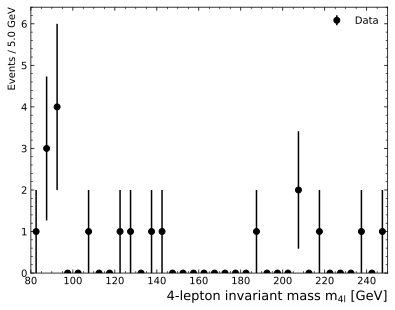

In [39]:
# x-axis range of the plot
xmin = 80 * GeV
xmax = 250 * GeV

# Histogram bin setup
step_size = 5 * GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

# Creating histogram from data
data_x,_ = np.histogram(ak.to_numpy(data_A['mass']), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

# *************
# Main plot 
# *************
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# draw the legend
main_axes.legend( frameon=False ); # no box around the legend

Great,
    we managed to plot `data_A`! 
Now, 
    we have not discussed how to deal with the Monte-Carlo simulation data,
    or even what they are for. 
Let us explain.

## Example 2: Reading Monte-Carlo data


Using the Standard Model, 
    we can do a set of randomised simulations to produce a set of theoretical data points to compare to our ATLAS data.
These are known as Monte-Carlo(MC) simulations.
There is one important change to be made to the MC data before we can compare them with our ATLAS data:
 - **Weights** - The MC data was computed in ideal circumstances. 
    The real ATLAS detector has some inefficiencies,
        which we can account for by attributing the appropriate weight to each data point.
    The weight of a data point affects how it contributes to the histogram count for its bin.

Let's open an MC file.

In [40]:
# We open an MC data file with sample value "Zee" using samples and infofile for reference of filenames
print(samples["Background $Z,t\\bar{t}$"])
value = samples["Background $Z,t\\bar{t}$"]["list"][0]

# This is now appended to our file path to retrieve the root file
background_Zee_path = path + "MC/mc_"+str(infofile.infos[value]["DSID"])+"."+value+".4lep.root"

# Accessing the file from the online directory
with uproot.open(background_Zee_path + ":mini") as t:
    tree = t

{'list': ['Zee', 'Zmumu', 'ttbar_lep'], 'color': '#6b59d3'}


Again, 
    not all weights are important to our analysis. 
In our case, 
    these are:
- `mcWeight` - specific Monte-Carlo weight associated with each event
- `scaleFactor_PILEUP` - scale factor for pileup reweighting
- `scaleFactor_ELE` - scale factor for electron efficiency
- `scaleFactor_MUON`- scale factor for muon efficiency
- `scaleFactor_LepTRIGGER` - scale factor for lepton triggers

Scale factors are generally related to estimates of the efficiencies and resolutions of detectors.

In [41]:
weight_variables = ["mcWeight", "scaleFactor_PILEUP", "scaleFactor_ELE", "scaleFactor_MUON", "scaleFactor_LepTRIGGER"]

# For example, see below for the weights corresponding to muon rejection
tree["scaleFactor_MUON"].arrays(library = "ak")

<Array [{scaleFactor_MUON: 0.984}, ..., {...}] type='898 * {scaleFactor_MUO...'>

Additionally,
    there is a cross-section weight $w_\sigma$ associated with each MC file.
We define this variable `xsec_weight` below. 
This weight is meant to normalise the entire Monte-Carlo distribution based on the number of events in the data.
This is its definition:
$$ w_\sigma = \frac{\int L \text{d}t ~ \sigma }{\eta \sum_i w_i } $$
where $\int L \text{d}t$ is the integrated luminosity (`lumi`),
    $\sigma$ is the cross section (`info["xsec"]`),
    $\eta$ is the filter efficiency of the MC generator,
    and $\sum_i w_i$ gives the sum of all weights (`info["sumw"]`).
When the integrated luminosity is multiplied by the cross section,
    it gives a measure of the total number of events during a period of data taking.
For `data_A`,
    the integrated luminosity has a value of $0.5 \,\text{fb}^{-1}$.

For more on cross sections and luminosities, 
    [see this cheatsheet](https://cds.cern.ch/record/2800578/files/Cross%20Section%20and%20Luminosity%20Physics%20Cheat%20Sheet.pdf).

In [42]:
lumi = 0.5 # fb-1 # data_A only
# lumi = 1.9 # fb-1 # data_B only
# lumi = 2.9 # fb-1 # data_C only
# lumi = 4.7 # fb-1 # data_D only
# lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

info = infofile.infos[value] # open infofile
xsec_weight = (lumi*1000*info["xsec"])/(info["red_eff"]*info["sumw"]) #*1000 to go from fb-1 to pb-1

Now,
    with all the weights we've defined, 
    we will calculate a total weight for an event,
    which is the collective product of all the weights.

In [43]:
# Let's use the first event of our tree
event = tree.arrays()[0]

# Multiply all the important weights together
total_weight = xsec_weight 
for variable in weight_variables:
    total_weight = total_weight * event[variable]
print(f"{total_weight = :.4f}")

total_weight = 0.0178


This calculation means that in our final histogram, 
    this event will be represented with ~0.0178 of a single count in the bin.
We can encapsulate these calculations in a single function `calc_weight`.

In [44]:
def calc_weight(weight_variables, sample, events):
    info = infofile.infos[sample]
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    total_weight = xsec_weight 
    for variable in weight_variables:
        total_weight = total_weight * events[variable]
    return total_weight

# Verify that we get the same answer
print(calc_weight(weight_variables, value, event))

0.017819365


Now, we can apply the cuts as before to plot the MC data.
The code is the same as before,
    but we make sure to add in `weight_variables` to our `tree.iterate()`,
    and we store the weights in each event using a new dictionary key.

In [45]:
sample_data = []

# Perform the cuts for each data entry in the tree
for data in tree.iterate(variables + weight_variables, library="ak", step_size = 1000000):
    # Cuts
    lep_type = data['lep_type']
    data = data[~cut_lep_type(lep_type)]
    lep_charge = data['lep_charge']
    data = data[~cut_lep_charge(lep_charge)]
    
    # Invariant Mass
    data['mass'] = calc_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_E'])

    # Store Monte Carlo weights in the data
    data['totalWeight'] = calc_weight(weight_variables, value, data)

    # Append data to the whole sample data list
    sample_data.append(data)

# turns sample_data back into an awkward array
Background_Zee = ak.concatenate(sample_data)

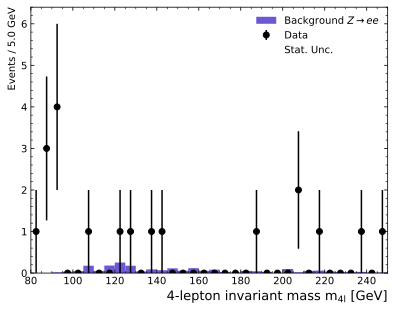

In [46]:
mc_x = ak.to_numpy(Background_Zee["mass"]) # define list to hold the Monte Carlo histogram entries
mc_weights = ak.to_numpy(Background_Zee["totalWeight"]) # define list to hold the Monte Carlo weights
mc_colors = samples["Background $Z,t\\bar{t}$"]['color'] # define list to hold the colors of the Monte Carlo bars
mc_labels = "Background $Z \\to ee$" # define list to hold the legend labels of the Monte Carlo bars

# *************
# Main plot 
# *************
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# plot the Monte Carlo bars
mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                            weights=mc_weights, stacked=True, 
                            color=mc_colors, label=mc_labels )

mc_x_tot = mc_heights[0] # stacked background MC y-axis value

# calculate MC statistical uncertainty: sqrt(sum w^2)
mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

# plot the statistical uncertainty
main_axes.bar(bin_centres, # x
                2*mc_x_err, # heights
                alpha=0.5, # half transparency
                bottom=mc_x_tot-mc_x_err, color='none', 
                hatch="////", width=step_size, label='Stat. Unc.' )

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# draw the legend
main_axes.legend( frameon=False ); # no box around the legend

## Final Analysis

Now that we understand all the steps of our analysis,
    all that's left is to import the entire ATLAS data and implement it.
The `samples` dictionary and `infofile.py` will be useful for this.

We will loop over all values in the `samples` dictionary.
Depending on whether it is a data sample or MC sample, 
    `fileString` will change,
    which opens the correct file on the open data folder.
As before, 
    the cuts, 
    mass calculations and MC weight calculations will be performed for each sample value,
    and then stored in the array.
The data will all be concatenated into `all_data` for plotting.

In [47]:
# Set luminosity to 10 fb-1 for all data
lumi = 10

# Controls the fraction of all events analysed
fraction = 1.0 # reduce this is if you want quicker runtime (implemented in the loop over the tree)

# Define empty dictionary to hold awkward arrays
all_data = {} 

# Loop over samples
for s in samples: 
    # Print which sample is being processed
    print('Processing '+s+' samples') 

    # Define empty list to hold data
    frames = [] 

    # Loop over each file
    for val in samples[s]['list']: 
        if s == 'data': 
            prefix = "Data/" # Data prefix
        else: # MC prefix
            prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
        fileString = path+prefix+val+".4lep.root" # file name to open


        # start the clock
        start = time.time() 
        print("\t"+val+":") 

        # Open file
        with uproot.open(fileString + ":mini") as t:
            tree = t
        
        sample_data = []

        # Loop over data in the tree
        for data in tree.iterate(variables + weight_variables, 
                                 library="ak", 
                                 entry_stop=tree.num_entries*fraction, # process up to numevents*fraction
                                 step_size = 1000000): 
            # Number of events in this batch
            nIn = len(data) 
                                 
            # Record transverse momenta (see bonus activity for explanation)
            data['leading_lep_pt'] = data['lep_pt'][:,0]
            data['sub_leading_lep_pt'] = data['lep_pt'][:,1]
            data['third_leading_lep_pt'] = data['lep_pt'][:,2]
            data['last_lep_pt'] = data['lep_pt'][:,3]

            # Cuts
            lep_type = data['lep_type']
            data = data[~cut_lep_type(lep_type)]
            lep_charge = data['lep_charge']
            data = data[~cut_lep_charge(lep_charge)]
            
            # Invariant Mass
            data['mass'] = calc_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_E'])

            # Store Monte Carlo weights in the data
            if 'data' not in val: # Only calculates weights if the data is MC
                data['totalWeight'] = calc_weight(weight_variables, val, data)
                nOut = sum(data['totalWeight']) # sum of weights passing cuts in this batch 
            else:
                nOut = len(data)
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after

            # Append data to the whole sample data list
            sample_data.append(data)

        frames.append(ak.concatenate(sample_data)) 

    all_data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays


Processing data samples
	data_A:
		 nIn: 39,	 nOut: 	27	 in 0.3s
	data_B:
		 nIn: 156,	 nOut: 	86	 in 0.2s
	data_C:
		 nIn: 237,	 nOut: 	146	 in 0.2s
	data_D:
		 nIn: 400,	 nOut: 	248	 in 0.2s
Processing Background $Z,t\bar{t}$ samples
	Zee:
		 nIn: 898,	 nOut: 	43.141792	 in 0.5s
	Zmumu:
		 nIn: 684,	 nOut: 	51.99949	 in 0.3s
	ttbar_lep:
		 nIn: 1031,	 nOut: 	28.132816	 in 0.3s
Processing Background $ZZ^*$ samples
	llll:
		 nIn: 554279,	 nOut: 	264.85263	 in 7.0s
Processing Signal ($m_H$ = 125 GeV) samples
	ggH125_ZZ4lep:
		 nIn: 164716,	 nOut: 	8.639792	 in 2.4s
	VBFH125_ZZ4lep:
		 nIn: 191126,	 nOut: 	0.7747851	 in 2.6s
	WH125_ZZ4lep:
		 nIn: 15379,	 nOut: 	0.2175638	 in 0.4s
	ZH125_ZZ4lep:
		 nIn: 14485,	 nOut: 	0.0015058718	 in 0.3s


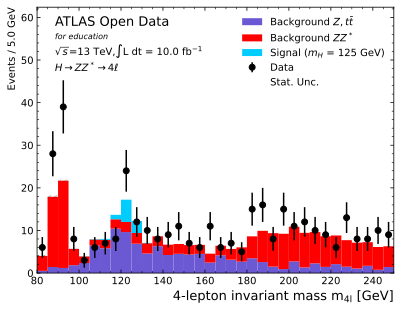

In [48]:
data_x,_ = np.histogram(ak.to_numpy(all_data['data']['mass']), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

signal_x = ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)']['mass']) # histogram the signal
signal_weights = ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)'].totalWeight) # get the weights of the signal events
signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

mc_x = [] # define list to hold the Monte Carlo histogram entries
mc_weights = [] # define list to hold the Monte Carlo weights
mc_colors = [] # define list to hold the colors of the Monte Carlo bars
mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

for s in samples: # loop over samples
    if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
        mc_x.append( ak.to_numpy(all_data[s]['mass']) ) # append to the list of Monte Carlo histogram entries
        mc_weights.append( ak.to_numpy(all_data[s].totalWeight) ) # append to the list of Monte Carlo weights
        mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
        mc_labels.append( s ) # append to the list of Monte Carlo legend labels

# *************
# Main plot 
# *************
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# plot the Monte Carlo bars
mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                            weights=mc_weights, stacked=True, 
                            color=mc_colors, label=mc_labels )

mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value

# calculate MC statistical uncertainty: sqrt(sum w^2)
mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

# plot the signal bar
signal_heights = main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                weights=signal_weights, color=signal_color,
                label=r'Signal ($m_H$ = 125 GeV)')

# plot the statistical uncertainty
main_axes.bar(bin_centres, # x
                2*mc_x_err, # heights
                alpha=0.5, # half transparency
                bottom=mc_x_tot-mc_x_err, color='none', 
                hatch="////", width=step_size, label='Stat. Unc.' )

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# Add text 'ATLAS Open Data' on plot
plt.text(0.05, # x
            0.93, # y
            'ATLAS Open Data', # text
            transform=main_axes.transAxes, # coordinate system used is that of main_axes
            fontsize=13 ) 

# Add text 'for education' on plot
plt.text(0.05, # x
            0.88, # y
            'for education', # text
            transform=main_axes.transAxes, # coordinate system used is that of main_axes
            style='italic',
            fontsize=8 ) 

# Add energy and luminosity
lumi_used = str(lumi*fraction) # luminosity to write on the plot
plt.text(0.05, # x
            0.82, # y
            '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
            transform=main_axes.transAxes ) # coordinate system used is that of main_axes

# Add a label for the analysis carried out
plt.text(0.05, # x
            0.76, # y
            r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
            transform=main_axes.transAxes ) # coordinate system used is that of main_axes

# draw the legend
main_axes.legend( frameon=False ) # no box around the legend

And there we have it. 
We have a nice peak in the invariant mass spectrum somewhere around $125 \, \text{GeV}$,
    the signature of the Higgs boson!

In addition to the Higgs peak, 
    we can see another peak around $91 \, \text{GeV}$, 
    corresponding to the Z boson from our background.


### Signal Significance

We can do some analysis to study how significant the signal is compared to the background. 
One method is to check a quantity known as the signal significance $S$,
    which is defined by 
$$ S = \frac{N_\text{sig}}{\sqrt{N_\text{bg}}}  $$
where $ N_\text{sig} $ and $N_\text{bg}$ are the number of signal and background points respectively.
A larger $S$ represents a better signal-to-background ratio,
    and a more significant signal peak.
To calculate $N_\text{sig}$, 
    we can look at the plot and sum over the number of events of our Monte-Carlo signal.
The signal range roughly corresponds to the bins from $115 \,\text{GeV}$ to $130 \, \text{GeV}$.
$N_\text{bg}$ then corresponds to the number of background events in those same bins.

However, 
    we must note that there are various systematic and experimental uncertainties in the operation of the experiment, 
    which we have not accounted for. 
Since our analysis is not completely accounting for these errors,
    we can add approximate these errors by adding in a factor of $0.3N_\text{bg}^2$ to the square root in the denominator.

In [49]:
# Signal stacked height
signal_tot = signal_heights[0] + mc_x_tot

# Peak of signal
print(signal_tot[8])

# Neighbouring bins
print(signal_tot[7:10])

# Signal and background events
N_sig = signal_tot[7:10].sum()
N_bg = mc_x_tot[7:10].sum()

# Signal significance calculation
signal_significance = N_sig/np.sqrt(N_bg + 0.3 * N_bg**2) 
print(f"\nResults:\n{N_sig = :.3f}\n{N_bg = :.3f}\n{signal_significance = :.3f}")

17.217453479766846
[13.66619015 17.21745348 12.21849871]

Results:
N_sig = 43.102
N_bg = 34.012
signal_significance = 2.208


There we go - we have a significance of $2.208$.
Our work is done here... or so you may think!
Here are some additional things you can do to play with this notebook:

* Check how many events are being thrown away by each cut 
* Add more cuts from the [Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#se0040) to see how it affects the signal-to-background ratio
* Add a plot to show the ratio between data and MC 
* Add a plot to show the invariant mass distribution of the sub-leading lepton pair, like [Figure 1 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0010)
* Get the estimated numbers of events, like [Table 3 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#tl0030)
* Add a plot of m12 against m34, like [Figure 3 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0030)
* Pretty much anything you like, let your imagination run wild!

## Bonus activity: Transverse momentum cuts

Can we do better than a significance of $2.208$?
Well, 
    there are many other kinematic variables in our data that can help us discriminate between signal and background.
One possible variable to look at is the transverse momentum $p_t$, 
stored as `lep_pt` in the tree.
In our final analysis code block,
    we recorded the transverse momenta of the leading, sub-leading, third-leading and last leptons 
    (the data had already been arranged in descending order of $p_t$).

To get a feel of the lepton momenta, 
    let's plot the various MC signal and backgrounds to see if we can make any cuts. 

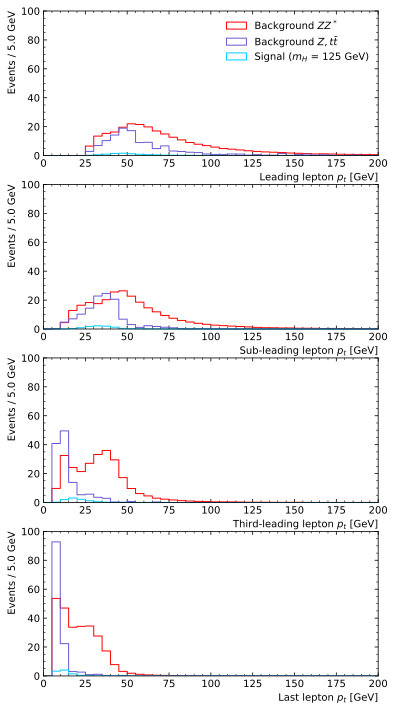

In [50]:
# x-axis range of the plot
xmin = 0 
xmax = 200 

bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values
                    
pt_keys = ['leading_lep_pt', 'sub_leading_lep_pt', 'third_leading_lep_pt', 'last_lep_pt']
signal_all = []
for key in pt_keys:
    signal_all.append(ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)'][key]*MeV)) 

signal_weights = ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)'].totalWeight) # get the weights of the signal events
signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

mc_all = [] # define lists to hold the Monte Carlo histogram entries
mc_weights = [] # define list to hold the Monte Carlo weights
mc_colors = [] # define list to hold the colors of the Monte Carlo bars
mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

for index in range(4):
    mc_all.append([]) 
    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_all[index].append(ak.to_numpy(all_data[s][pt_keys[index]]*MeV)) 

for s in samples: # loop over samples
    if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
        mc_weights.append( ak.to_numpy(all_data[s].totalWeight) ) # append to the list of Monte Carlo weights
        mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
        mc_labels.append( s ) # append to the list of Monte Carlo legend labels

# *************
# Main plot 
# *************
fig, ax = plt.subplots(4,1, figsize = (6,12))

for axis in range(4):
    # plot the Monte Carlo bars
    ax[axis].hist(mc_all[axis], bins=bin_edges, 
                            weights=mc_weights, stacked=False, 
                            color=mc_colors, label=mc_labels, histtype=u'step')

    # plot the signal bar
    ax[axis].hist(signal_all[axis], bins=bin_edges,
                    weights=signal_weights, color=signal_color,
                    label=r'Signal ($m_H$ = 125 GeV)', histtype=u'step');

    # set the x-limit of the main axes
    ax[axis].set_xlim(left=xmin, right=xmax) 

    # separation of x axis minor ticks
    ax[axis].xaxis.set_minor_locator( AutoMinorLocator() ) 

    # set the axis tick parameters for the main axes
    ax[axis].tick_params(which='both', # ticks on both x and y axes
                            direction='in', # Put ticks inside and outside the axes
                            top=True, # draw ticks on the top axis
                            right=True ) # draw ticks on right axis

    # write y-axis label for main axes
    ax[axis].set_ylabel('Events / '+str(step_size)+' GeV',
                            y=1, horizontalalignment='right') 

    # set y-axis limits for main axes
    ax[axis].set_ylim( bottom=0, top=100 )

    # add minor ticks on y-axis for main axes
    ax[axis].yaxis.set_minor_locator( AutoMinorLocator() ) 


# x-axis label
labels = [r'Leading lepton $p_t$ [GeV]', r'Sub-leading lepton $p_t$ [GeV]',
          r'Third-leading lepton $p_t$ [GeV]',r'Last lepton $p_t$ [GeV]']
for axis in range(4):
    ax[axis].set_xlabel(labels[axis],
                        fontsize=10, x=1, horizontalalignment='right' )
# draw the legend
ax[0].legend( frameon=False ) # no box around the legend

We can see from these plots that we could improve the signal-to-background by cutting away regions that have large backgrounds but small signals. Let us make the following selections:
- $>30\, \text{GeV}$ for leading $p_t$
- $>20\, \text{GeV}$ for sub-leading $p_t$
- $>10\, \text{GeV}$ for third-leading $p_t$

In [51]:
cutoffs = [30, 20, 10]

Why don't we add an upper bound cut? 
This is because the high energy tails of our distribution are often important parts of the data.
For one, 
    if we cut away the high energy parts of the data,
    we could potentially be removing a portion that reveals new physics.
Such new physics could lie beyond the standard model,
    only appearing at higher energies!
Thus, 
    we should be careful not to purposefully exclude such data from our analysis.

Now that we have our cutoffs,
    we should implement them in our analysis.
Note the addition of the lines in the form

`data = data[data['leading_lep_pt'] * MeV > cutoffs[0]]`

which keeps only events that lie above the cutoff.

In [52]:
# Set luminosity to 10 fb-1 for all data
lumi = 10

# Controls the fraction of all events analysed
fraction = 1.0 # reduce this is if you want quicker runtime (implemented in the loop over the tree)

# Define empty dictionary to hold awkward arrays
all_data = {} 

# Loop over samples
for s in samples: 
    # Print which sample is being processed
    print('Processing '+s+' samples') 

    # Define empty list to hold data
    frames = [] 

    # Loop over each file
    for val in samples[s]['list']: 
        if s == 'data': 
            prefix = "Data/" # Data prefix
        else: # MC prefix
            prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
        fileString = path+prefix+val+".4lep.root" # file name to open


        # start the clock
        start = time.time() 
        print("\t"+val+":") 

        # Open file
        with uproot.open(fileString + ":mini") as t:
            tree = t
        
        sample_data = []

        # Loop over data in the tree
        for data in tree.iterate(variables + weight_variables, 
                                 library="ak", 
                                 entry_stop=tree.num_entries*fraction, # process up to numevents*fraction
                                 step_size = 1000000): 
            # Number of events in this batch
            nIn = len(data) 
                                 
            # Transverse momentum records and cuts
            data['leading_lep_pt'] = data['lep_pt'][:,0]
            data['sub_leading_lep_pt'] = data['lep_pt'][:,1]
            data['third_leading_lep_pt'] = data['lep_pt'][:,2]
            data['last_lep_pt'] = data['lep_pt'][:,3]

            data = data[data['leading_lep_pt'] * MeV > cutoffs[0]]
            data = data[data['sub_leading_lep_pt'] * MeV > cutoffs[1]]
            data = data[data['third_leading_lep_pt'] * MeV > cutoffs[2]]

            # Cuts
            lep_type = data['lep_type']
            data = data[~cut_lep_type(lep_type)]
            lep_charge = data['lep_charge']
            data = data[~cut_lep_charge(lep_charge)]
            
            # Invariant Mass
            data['mass'] = calc_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_E'])

            # Store Monte Carlo weights in the data
            if 'data' not in val: # Only calculates weights if the data is MC
                data['totalWeight'] = calc_weight(weight_variables, val, data)
                nOut = sum(data['totalWeight']) # sum of weights passing cuts in this batch 
            else:
                nOut = len(data)
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after

            # Append data to the whole sample data list
            sample_data.append(data)

        frames.append(ak.concatenate(sample_data)) 

    all_data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays

Processing data samples
	data_A:
		 nIn: 39,	 nOut: 	21	 in 0.2s
	data_B:
		 nIn: 156,	 nOut: 	66	 in 0.2s
	data_C:
		 nIn: 237,	 nOut: 	116	 in 0.2s
	data_D:
		 nIn: 400,	 nOut: 	209	 in 0.4s
Processing Background $Z,t\bar{t}$ samples
	Zee:
		 nIn: 898,	 nOut: 	26.915932	 in 0.2s
	Zmumu:
		 nIn: 684,	 nOut: 	28.59276	 in 0.2s
	ttbar_lep:
		 nIn: 1031,	 nOut: 	18.368776	 in 0.2s
Processing Background $ZZ^*$ samples
	llll:
		 nIn: 554279,	 nOut: 	236.67665	 in 5.5s
Processing Signal ($m_H$ = 125 GeV) samples
	ggH125_ZZ4lep:
		 nIn: 164716,	 nOut: 	7.929783	 in 2.4s
	VBFH125_ZZ4lep:
		 nIn: 191126,	 nOut: 	0.7252958	 in 2.6s
	WH125_ZZ4lep:
		 nIn: 15379,	 nOut: 	0.2036293	 in 0.5s
	ZH125_ZZ4lep:
		 nIn: 14485,	 nOut: 	0.0014187315	 in 0.4s


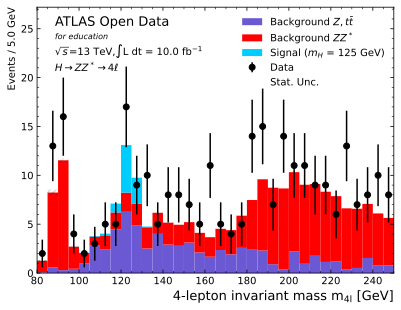

In [53]:
# x-axis range of the plot
xmin = 80 * GeV
xmax = 250 * GeV

bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

data_x,_ = np.histogram(ak.to_numpy(all_data['data']['mass']), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

signal_x = ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)']['mass']) # histogram the signal
signal_weights = ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)'].totalWeight) # get the weights of the signal events
signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

mc_x = [] # define list to hold the Monte Carlo histogram entries
mc_weights = [] # define list to hold the Monte Carlo weights
mc_colors = [] # define list to hold the colors of the Monte Carlo bars
mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

for s in samples: # loop over samples
    if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
        mc_x.append( ak.to_numpy(all_data[s]['mass']) ) # append to the list of Monte Carlo histogram entries
        mc_weights.append( ak.to_numpy(all_data[s].totalWeight) ) # append to the list of Monte Carlo weights
        mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
        mc_labels.append( s ) # append to the list of Monte Carlo legend labels

# *************
# Main plot 
# *************
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# plot the Monte Carlo bars
mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                            weights=mc_weights, stacked=True, 
                            color=mc_colors, label=mc_labels )

mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value

# calculate MC statistical uncertainty: sqrt(sum w^2)
mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

# plot the signal bar
main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                weights=signal_weights, color=signal_color,
                label=r'Signal ($m_H$ = 125 GeV)')

# plot the statistical uncertainty
main_axes.bar(bin_centres, # x
                2*mc_x_err, # heights
                alpha=0.5, # half transparency
                bottom=mc_x_tot-mc_x_err, color='none', 
                hatch="////", width=step_size, label='Stat. Unc.' )

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# Add text 'ATLAS Open Data' on plot
plt.text(0.05, # x
            0.93, # y
            'ATLAS Open Data', # text
            transform=main_axes.transAxes, # coordinate system used is that of main_axes
            fontsize=13 ) 

# Add text 'for education' on plot
plt.text(0.05, # x
            0.88, # y
            'for education', # text
            transform=main_axes.transAxes, # coordinate system used is that of main_axes
            style='italic',
            fontsize=8 ) 

# Add energy and luminosity
lumi_used = str(lumi*fraction) # luminosity to write on the plot
plt.text(0.05, # x
            0.82, # y
            '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
            transform=main_axes.transAxes ) # coordinate system used is that of main_axes

# Add a label for the analysis carried out
plt.text(0.05, # x
            0.76, # y
            r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
            transform=main_axes.transAxes ) # coordinate system used is that of main_axes

# draw the legend
main_axes.legend( frameon=False ) # no box around the legend

### Signal Significance (post $p_t$ cuts)

We can now check our signal significance to see if it has improved after our cuts.

In [54]:
# Signal stacked height
signal_tot = signal_heights[0] + mc_x_tot

# Peak of signal
print(signal_tot[8])

# Neighbouring bins
print(signal_tot[7:10])

# Signal and background events
N_sig = signal_tot[7:10].sum()
N_bg = mc_x_tot[7:10].sum()

# Signal significance calculation
signal_significance = N_sig/np.sqrt(N_bg + 0.3 * N_bg**2) 
print(f"\nResults:\n{N_sig = :.3f}\n{N_bg = :.3f}\n{signal_significance = :.3f}")

13.454927921295166
[ 7.24330521 13.45492792  9.92100382]

Results:
N_sig = 30.619
N_bg = 21.529
signal_significance = 2.416


Amazing! 
With the addition of those cuts,
    our significance increased from $2.108$ to $2.416$!

## Frequently Asked Questions (FAQ)


**Q**: How do we know the mass of the Higgs boson is $125 \,\text{GeV}$?

**A**: The mass of the Higgs boson is not predicted by the Standard Model. 
It is a free parameter of the theory.
To determine its value,
    multiple analyses must be performed,
    similar to this one,
    but for different decay channels.
In doing this, 
    we spot a consistent peak in mass at $125 \,\text{GeV}$ across the different decays,
    which is strong evidence for it being the mass of the Higgs. 

**Q**: Why do we filter for more than four leptons, and not exactly four leptons?

**A**: The lepton recognition algorithms are not always perfect. 
Sometimes,
    there may be additional particles in the process which are misidentified as leptons.
This leads to five or even six "leptons" in a four-lepton process.
However, 
    since the leptons are sorted in order of their energies, 
    we always look at the four most energetic leptons,
    which are most likely to be part of the process of interest.
Nevertheless,
    you are welcome to add a cut to the number of leptons. 
See if it improves the signal significance!